In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Testing Causal Monarch Matrices

The goal of this notebook is to test out some of our ideas about making Monarch convolutions causal.

First, we'll show that the DFT convolution is causal, with some padding. We'll be using a numerical test of causality (see Section 1.1 below).

Then, we'll try out some causal Monarch convolutions, with two padding schemes:
* Pad the 1D input of length $N$ to length $4N$
* Reshape the 1D input to length $\sqrt{N} \times \sqrt{N}$, and pad with zeros to $N \times N$

Both of these seem to fail the causality test (2.4 and 2.6 below), so something may be wrong with our interpretation or implementation.

I've notated in <font color='red'>red text</font> some places where I think things could be going wrong.

Table of Contents:
* Section 1 shows the DFT matrices, and padding in 1D
* Section 1.1 shows a numerical test of causality
* Section 2.1 shows general Monarch matrices
* Section 2.2 shows causal Monarch matrices
* Section 2.3 shows using causal Monarch matrices with padding in 1D
* Section 2.4 shows the numerical test that fails for causal Monarch matrices with padding in 1D
* Section 2.5 padding in 2D
* Section 2.6 shows padding in 2D failing the numerical test of causality, and graphs something that may be a hint about what's going wrong?

In [2]:
def ref_dft_matrix(N):
    """Compute the DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    M = torch.exp(-2j * torch.pi * n * k / N)
    return torch.view_as_real(M)

def ref_idft_matrix(N):
    """Compute the inverse DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    M = torch.exp(2j * torch.pi * n * k / N) / N
    return torch.view_as_real(M)

In [3]:
def fftconv(u, k, N):
    fft_size = 2 * N
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.complex64)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.complex64)

    fft_mat = torch.view_as_complex(ref_dft_matrix(fft_size))
    ifft_mat = torch.view_as_complex(ref_idft_matrix(fft_size))

    k_f = torch.einsum('n o, o -> n', fft_mat, k)
    u_f = torch.einsum('n o, o -> n', fft_mat, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', ifft_mat, prod).real[:N]

def ref_fftconv(u, k, N):
    fft_size = 2 * N

    k_f = torch.fft.fft(k.to(torch.complex64), n=fft_size)
    u_f = torch.fft.fft(u.to(torch.complex64), n=fft_size)

    prod = k_f * u_f
    return torch.fft.ifft(prod, n=fft_size).real[:N]

# 1 Test DFT Convolution Causality

We use the DFT to compute a causal convolution of two signals $u$ and $k$, of size $N$. Let $F_N$, $iF_N$ be the DFT and inverse DFT matrices of size $N$.

We do so as follows:
* We pad both $u$ and $k$ with $N$ extra zero's so that their lengths are $2N$.
* Then, we can compute $y = u \ast k$ by taking $iF_{2N} ((F_{2N} u) \odot (F_{2N} k))$, where $\odot$ represents element-wise multiplication, and taking the first $N$ elements of the output.

Here are visual depictions of the padded $u$ and $k$, and the DFT and inverse DFT matrices. Note that $N = 16$.

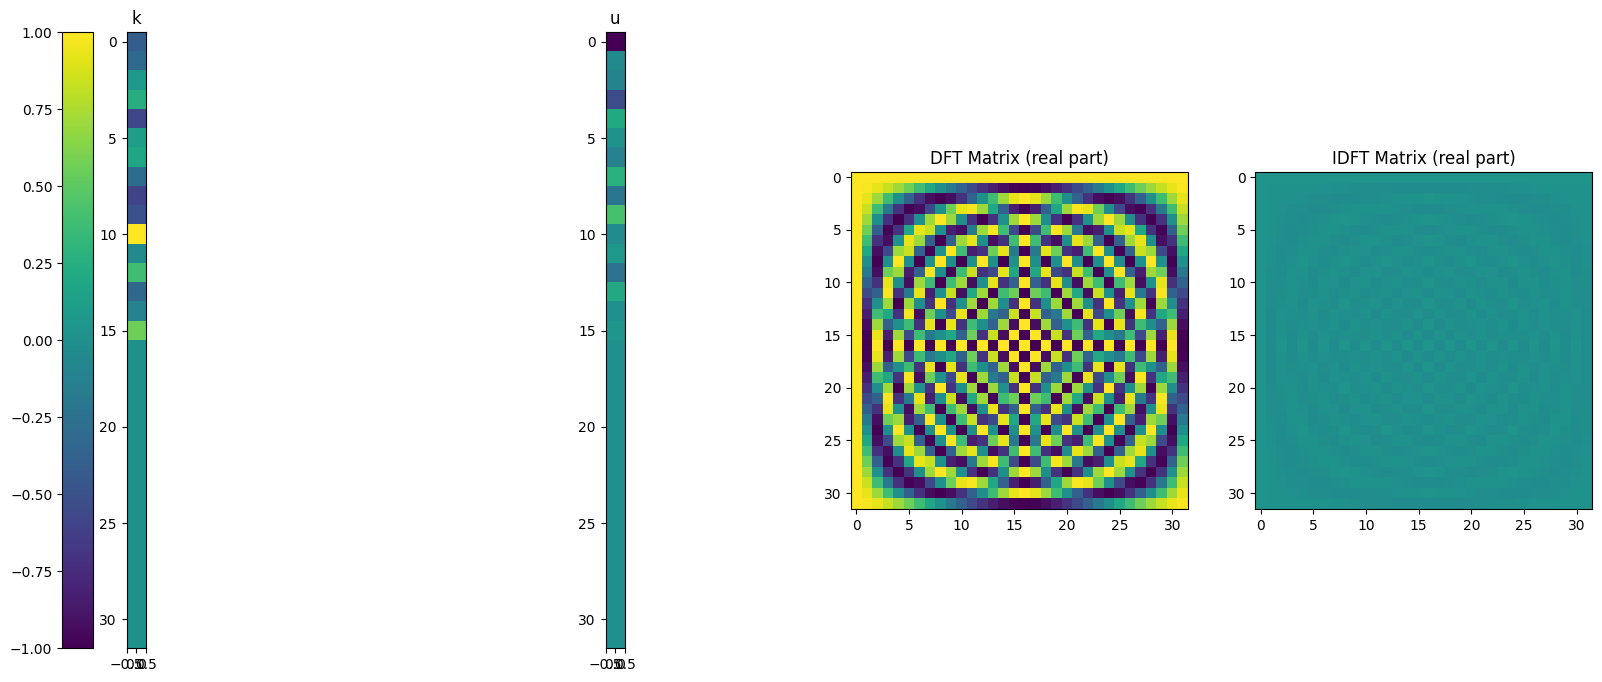

In [4]:
N = 16

k = torch.randn(N)
u = torch.randn(N)

# visual demonstration of the inputs to this model
fft_size = 2 * N
k_padded = nn.ConstantPad1d((0, fft_size - N), 0)(k).unsqueeze(1) / torch.max(torch.abs(k))
u_padded = nn.ConstantPad1d((0, fft_size - N), 0)(u).unsqueeze(1)/ torch.max(torch.abs(u))

fft_mat = ref_dft_matrix(fft_size)[..., 0]
ifft_mat = ref_idft_matrix(fft_size)[..., 0]

# plot four subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
axs[0].imshow(k_padded, vmin=-1, vmax=1)
axs[0].set_title('k')
axs[1].imshow(u_padded, vmin=-1, vmax=1)
axs[1].set_title('u')
axs[2].imshow(fft_mat, vmin=-1, vmax=1)
axs[2].set_title('DFT Matrix (real part)')
pcm = axs[3].imshow(ifft_mat, vmin=-1, vmax=1)
axs[3].set_title('IDFT Matrix (real part)')
fig.colorbar(pcm, ax=axs[0], location='left')

In [5]:
# check that the FFT is correct
ref_y = ref_fftconv(u, k, N)
y = fftconv(u, k, N)

print(torch.max(torch.abs(y - ref_y)))

tensor(2.5034e-06)


In [6]:
# test causality by changing the last element of u, and seeing if the output changes

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(fftconv(u_changed, k, N))

new_ys = torch.stack(new_ys)

## 1.1 This is what a Causal Convolution Looks Like

How to read this plot:
* Each row graphs $|(u' \ast k) - (u \ast k)|$ for a particular $u'$
* In the top row, $u' == u$, with last value changed
* In the second row, the last two values of $u'$ are changed from $u$, etc.
* If the above graph looks triangular, then the $\ast$ operation is causal!

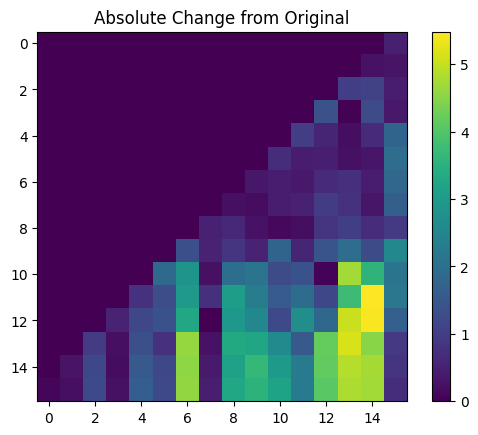

In [7]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()

Great! Our standard DFT convolution with padding is causal.

# 2. Monarch Convolution Causality

## 2.1 General Monarch Matrices

From the notes, this is my understanding of what should be causal Monarch matrices:

For a general $N \times N$ Monarch matrix, we have $M = LR$, where $R$ is a block-diagonal matrix (with $\sqrt{N}$ blocks) and $L$ is a block matrix where each block is diagonal.

Here is what that could look like:

In [8]:
def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

General Monarch


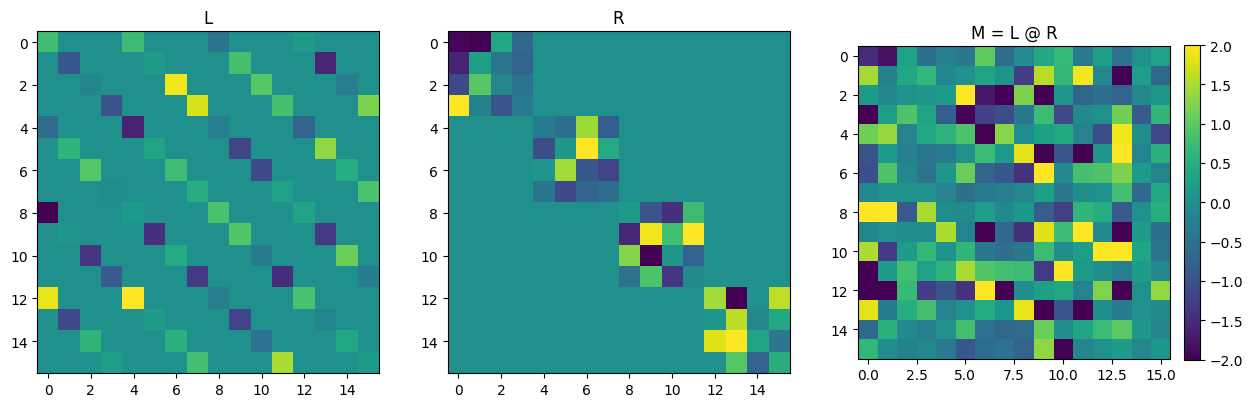

In [9]:
N = 16
sqrt_N = 4
monarch_r = torch.zeros(N, N)
monarch_l = torch.zeros(N, N)

for i in range(sqrt_N):
    monarch_r[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = torch.randn((sqrt_N, sqrt_N))

for i in range(sqrt_N):
    for j in range(sqrt_N):
        monarch_l[i * sqrt_N:(i + 1) * sqrt_N, j * sqrt_N:(j + 1) * sqrt_N] = torch.diag(torch.randn(sqrt_N))

monarch_m = monarch_l @ monarch_r

print('General Monarch')
plot_monarch(monarch_l, monarch_r, monarch_m)

## 2.2 Causal Monarch Matrices

We wish to use Monarch matrices to replace the DFT matrices $F_{2N}$ and $iF_{2N}$ in the DFT convolution, and make sure that the output is causal.

From the discussion with Jess and Isys, I believe these are the conditions on L and R to make the Monarch convolution causal. <font color='red'>There is something wrong here -- the test below shows this is not causal!</font>
* $R$ can be arbitrary as defined above.
* $L$ is a matrix that looks like this: in each block, the diagonal elements must all be the same, and the values are determined by $X_i^j$, where $i$ is the block row, and $j$ is the block column.

Here is what that could look like:

In [10]:
def causal_monarch(N, sqrt_N):
    monarch_r = torch.zeros(N, N)
    monarch_l = torch.zeros(N, N)

    for i in range(sqrt_N):
        monarch_r[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = torch.randn((sqrt_N, sqrt_N))

    xi = torch.randn(sqrt_N)
    for i in range(sqrt_N):
        for j in range(sqrt_N):
            monarch_l[i * sqrt_N:(i + 1) * sqrt_N, j * sqrt_N:(j + 1) * sqrt_N] = torch.diag(torch.pow(xi[i:i+1], j).repeat(sqrt_N))

    monarch_m = monarch_l @ monarch_r

    return monarch_m, monarch_l, monarch_r

Causal Monach


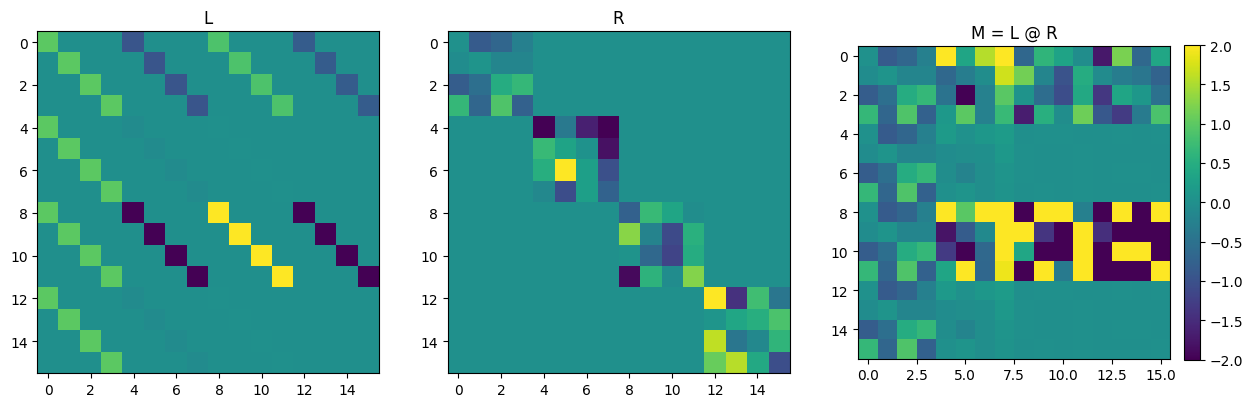

In [11]:
m, ml, mr = causal_monarch(N, sqrt_N)

print('Causal Monach')
plot_monarch(ml, mr, m)

## 2.3 Test these Monarch Matrices

Now, we'll test whether we can using these Monarch matrices to replace the DFT matrices results in a causal convolution, **in the same way as we made the DFT matrix causal**:
* We pad both $u$ and $k$ with $N$ extra zero's so that their lengths are $2N$... <font color='red'>Something seems wrong here!</font> - how can you generally get a Monarch matrix of size $2N$? Then you have $\sqrt{2N}$ blocks...
* In my implementation below, I'll fix this by padding up to $4N$, but I don't like this :)
* We generate $M_1$, $M_2$, $M_3$ as above, and use them to compute $y$: $y = M_3^{-1} ((M_1 u) \odot (M_2 k))$


M1


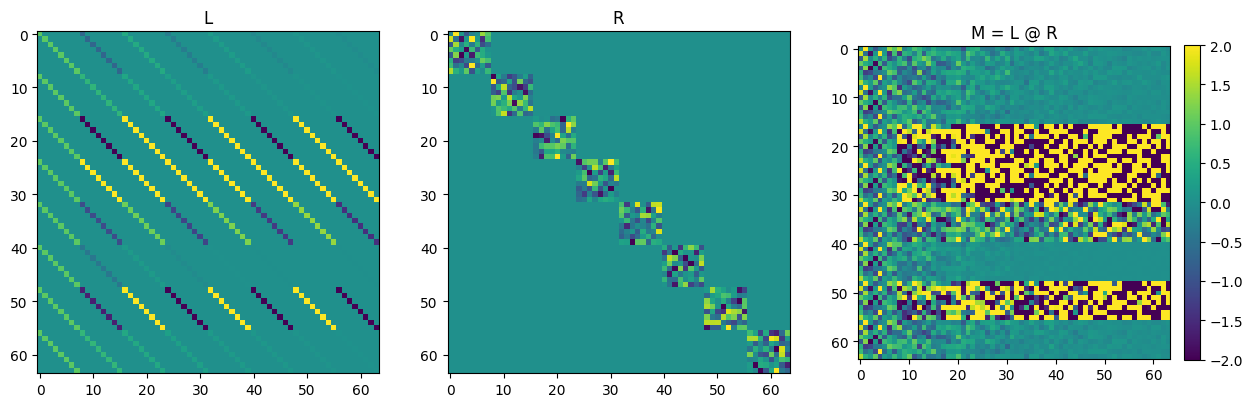

M2


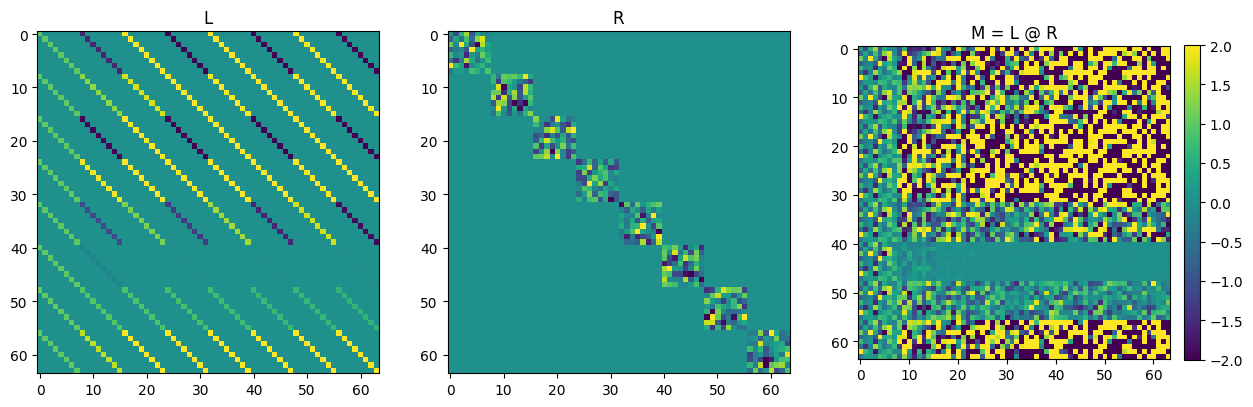

M3


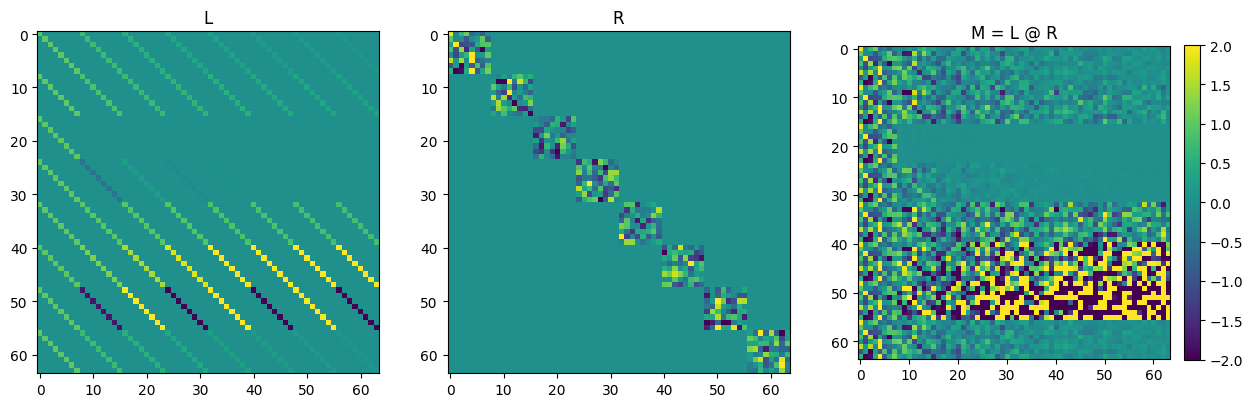

In [12]:
N = 16
sqrt_N = 4

M1, L1, R1 = causal_monarch(4 * N, 2 * sqrt_N)
M2, L2, R2 = causal_monarch(4 * N, 2 * sqrt_N)
M3, L3, R3 = causal_monarch(4 * N, 2 * sqrt_N)

M3_inv = torch.inverse(M3)

print('M1')
plot_monarch(L1, R1, M1)
plt.show()
print('M2')
plot_monarch(L2, R2, M2)
plt.show()
print('M3')
plot_monarch(L3, R3, M3)
plt.show()

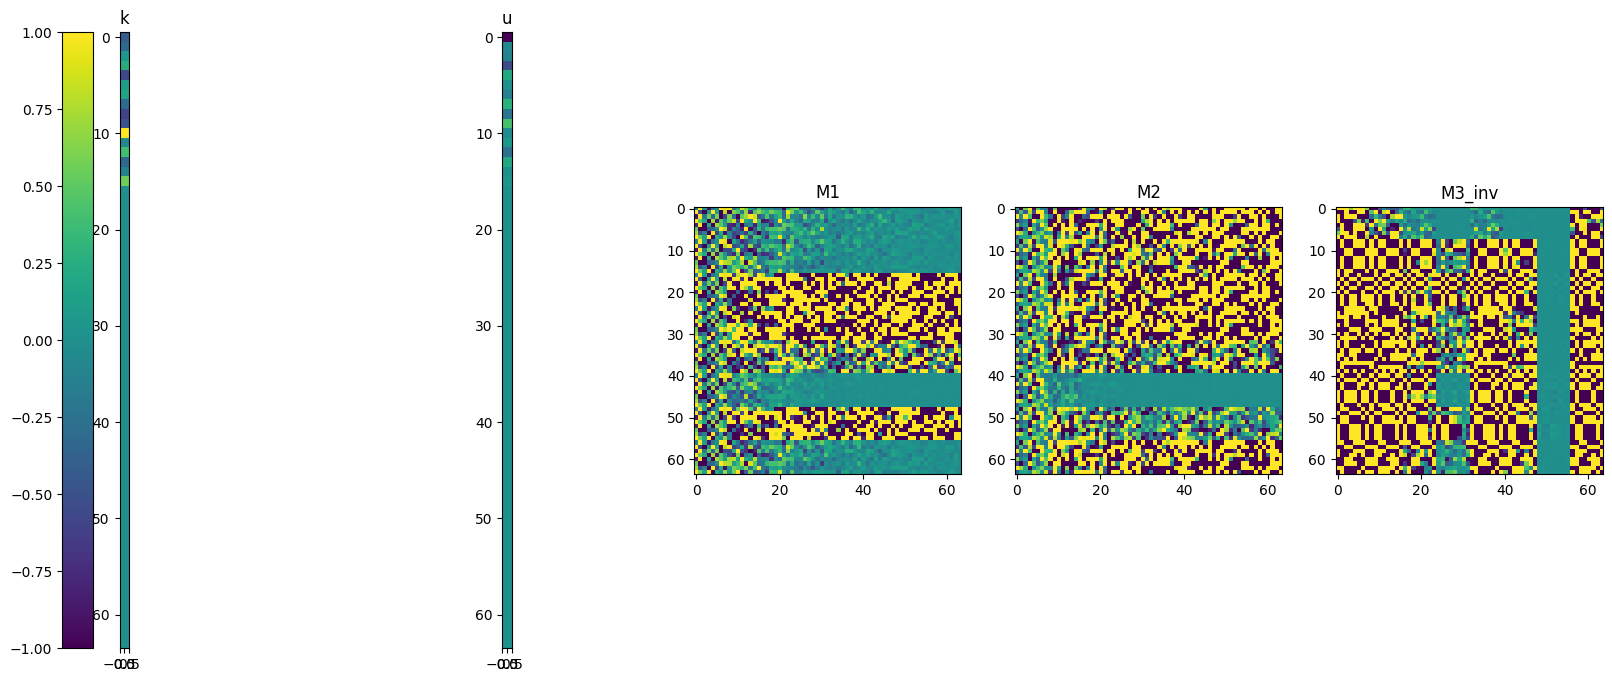

In [13]:
monarch_fft_size = 4 * N
k_padded = nn.ConstantPad1d((0, monarch_fft_size - N), 0)(k).unsqueeze(1) / torch.max(torch.abs(k))
u_padded = nn.ConstantPad1d((0, monarch_fft_size - N), 0)(u).unsqueeze(1)/ torch.max(torch.abs(u))

# plot four subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 8))
axs[0].imshow(k_padded, vmin=-1, vmax=1)
axs[0].set_title('k')
axs[1].imshow(u_padded, vmin=-1, vmax=1)
axs[1].set_title('u')
axs[2].imshow(M1, vmin=-1, vmax=1)
axs[2].set_title('M1')
axs[3].imshow(M2, vmin=-1, vmax=1)
axs[3].set_title('M2')
pcm = axs[4].imshow(M3_inv, vmin=-1, vmax=1)
axs[4].set_title('M3_inv')
fig.colorbar(pcm, ax=axs[0], location='left')

In [14]:
def monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = 4 * N
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N]

In [15]:
# test causality by changing the last element of u, and seeing if the output changes

y = monarch_fft_conv(u, k, N, M1, M2, M3_inv)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(monarch_fft_conv(u_changed, k, N, M1, M2, M3_inv))

new_ys = torch.stack(new_ys)

## 2.4 Causal Monarch Matrices Results (pad to 4N)

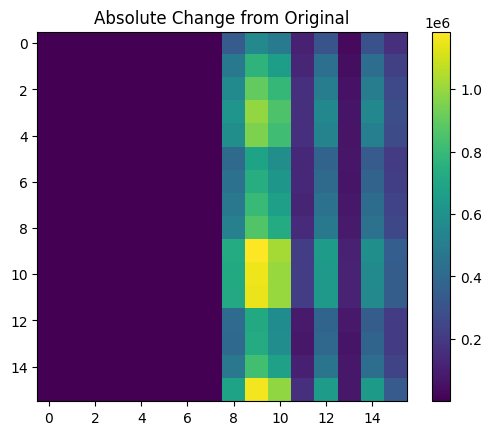

In [16]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()

### The test above seems to have failed -- this does not look causal!

There are two places where I think my understanding is broken:
* The exact form of the causal Monarch matrix -- there must be some extra conditions that we are not getting
* The way we pad the input to make it causal

## 2.5 Different Padding Strategy

We try a different padding strategy:
* Reshape a vector $u$ of length $N$ into a matrix $U$ of size $\sqrt{N} \times \sqrt{N}$
* Pad $U$ with $N$ extra zero's so that the size is $N \times N$
* Use matrix multiplication instead of Matrix-Vector multiplication to compute $y = M_3^{-1} ((M_1 U) \odot (M_2 K))$

In [17]:
def pad_2d(x, N, sqrt_N):
    x = x.reshape((sqrt_N, sqrt_N))
    x = nn.ConstantPad2d((0, N - sqrt_N, 0, N - sqrt_N), 0)(x)

    return x

def unpad_2d(x, N, sqrt_N):
    return x[:sqrt_N, :sqrt_N].reshape((N,))

M1


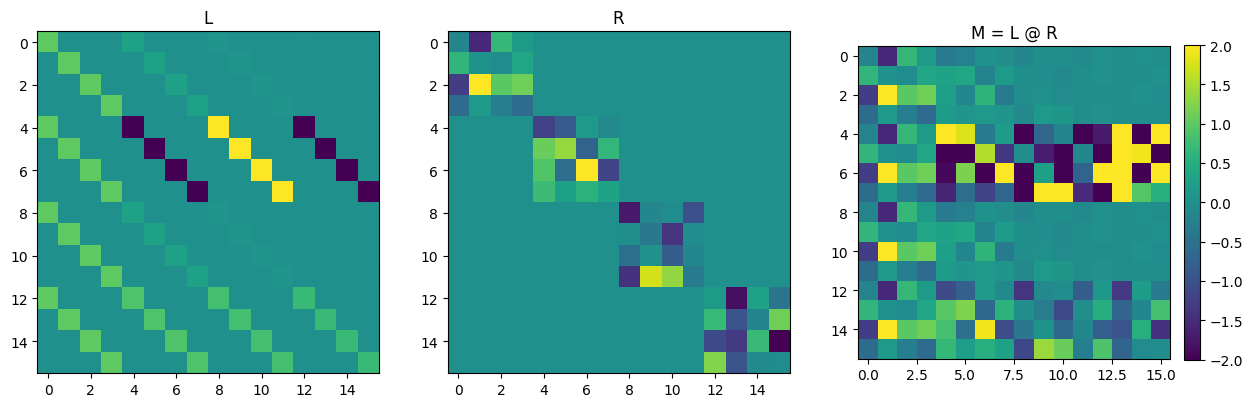

M2


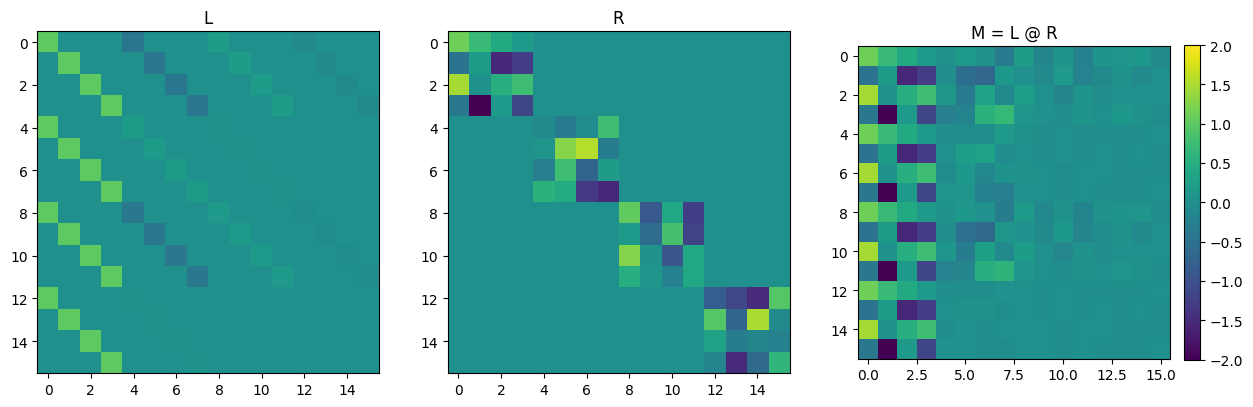

M3


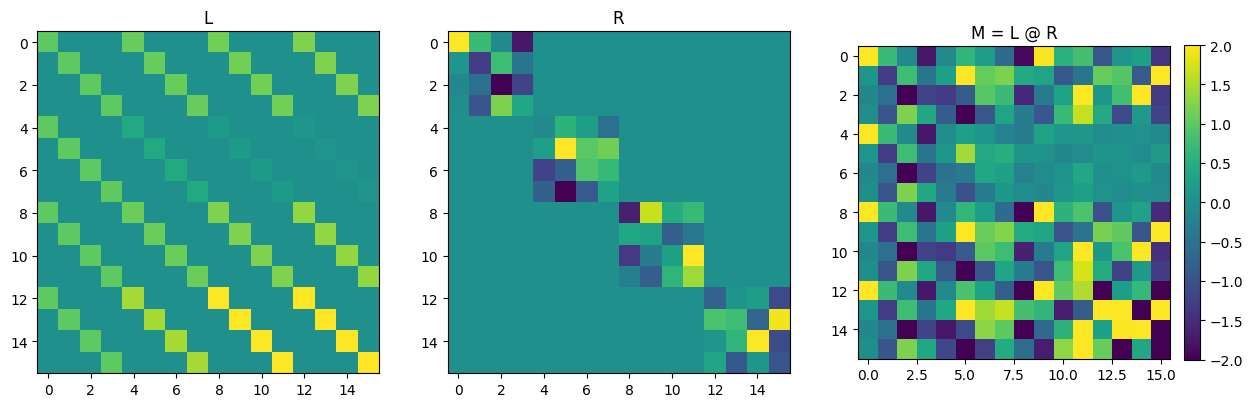

In [18]:
N = 16
sqrt_N = 4

M1, L1, R1 = causal_monarch(N, sqrt_N)
M2, L2, R2 = causal_monarch(N, sqrt_N)
M3, L3, R3 = causal_monarch(N, sqrt_N)

M3_inv = torch.inverse(M3)

print('M1')
plot_monarch(L1, R1, M1)
plt.show()
print('M2')
plot_monarch(L2, R2, M2)
plt.show()
print('M3')
plot_monarch(L3, R3, M3)
plt.show()

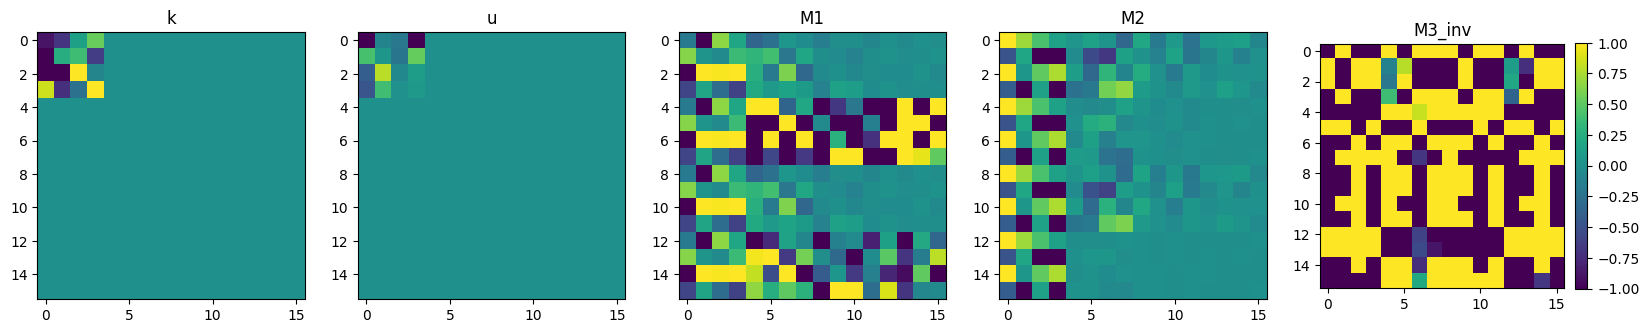

In [19]:
k_2d_padded = pad_2d(k, N, sqrt_N)
u_2d_padded = pad_2d(u, N, sqrt_N)

# plot four subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 8))
axs[0].imshow(k_2d_padded, vmin=-1, vmax=1)
axs[0].set_title('k')
axs[1].imshow(u_2d_padded, vmin=-1, vmax=1)
axs[1].set_title('u')
axs[2].imshow(M1, vmin=-1, vmax=1)
axs[2].set_title('M1')
axs[3].imshow(M2, vmin=-1, vmax=1)
axs[3].set_title('M2')
pcm = axs[4].imshow(M3_inv, vmin=-1, vmax=1)
axs[4].set_title('M3_inv')
fig.colorbar(pcm, ax=axs[4], fraction=0.046, pad=0.04)

In [20]:
def monarch_fft_conv_2d(u, k, N, M1, M2, M3_inv):
    k = pad_2d(k, N, sqrt_N)
    u = pad_2d(u, N, sqrt_N)

    k_f = M1 @ k
    u_f = M2 @ u

    prod = k_f * u_f
    y_f = M3_inv @ prod

    return unpad_2d(y_f, N, sqrt_N)

In [21]:
# test causality by changing the last element of u, and seeing if the output changes

y = monarch_fft_conv_2d(u, k, N, M1, M2, M3_inv)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(monarch_fft_conv_2d(u_changed, k, N, M1, M2, M3_inv))

new_ys = torch.stack(new_ys)

## 2.6 Causal Monarch Matrices Results (pad in 2D)

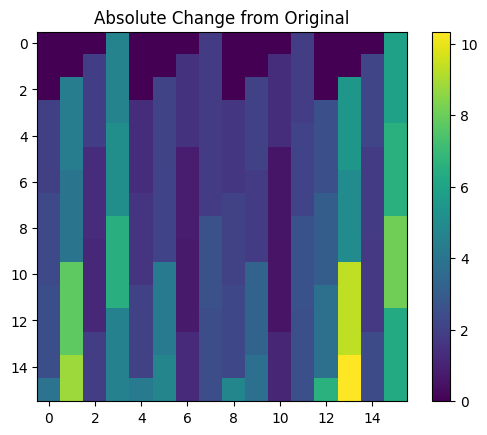

In [22]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()

### Maybe this is a hint about what's going wrong?

Here, each block shows the differences above, reshaped to be in 2D. The first cell shows the changes from only change the last element of $u$, the second cell shows the changes from changing the last two elements of $u$, etc.

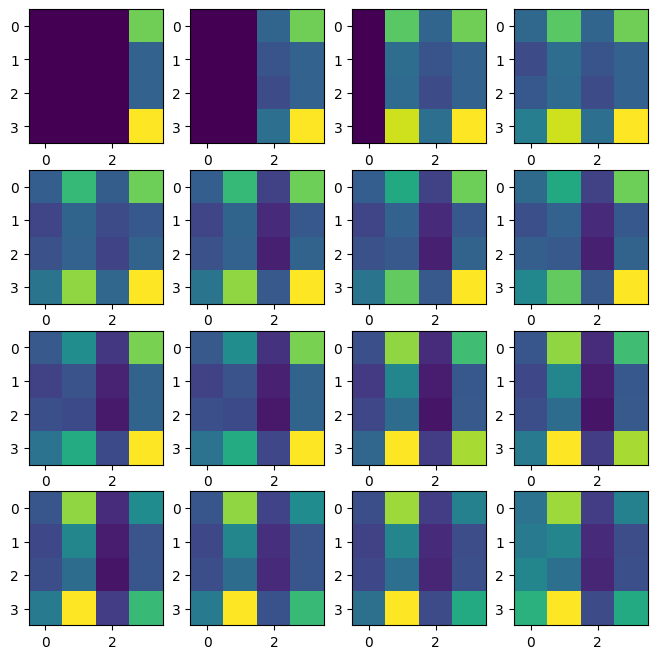

In [23]:
fig, axs = plt.subplots(sqrt_N, sqrt_N, figsize=(8, 8))
for i in range(sqrt_N):
    for j in range(sqrt_N):
        axs[i, j].imshow(torch.abs(new_ys[i * sqrt_N + j] - y).reshape((sqrt_N, sqrt_N)), vmin=0)